<a href="https://colab.research.google.com/github/ashikshafi08/Learning_Tensorflow/blob/main/Straight%20From%20Docs/Load_Images_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Images with TensorFlow 

This notebook contains two ways of loading and preprocessing image data. First will use the high-level Keras preprocessing [utilities](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) and [layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing) to read a directory out of images. 

Another way would be writing an input pipeline from scratch using `tf.data`. 

In [1]:
# Importing the things we will be need
import tensorflow as tf
import tensorflow_datasets as tfds 
import numpy as np 
import os 
import PIL 
import PIL.Image 

In [2]:
# What GPU we're running on ? 
!nvidia-smi

Sat Apr 17 13:53:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

At first let's download the dataset. The flower dataset contains several thousand photos of flowers. The flowers dataset contains 5 sub-directories, one per class:

```
flowers_photos/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```


### Downlading the data

In [3]:
import pathlib 

# Getting the dataset url
dataset_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'

# Getting the files (More like fastai untar_data)
data_dir = tf.keras.utils.get_file(origin= dataset_url , 
                                   fname = 'flower_photos' , 
                                   untar = True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 1s 0us/step


Look into [tf.keras.utils.get_files](https://www.tensorflow.org/api_docs/python/tf/keras/utils/get_file)

It works more like fastai's untar_data, it downloads a file from the given URL. 

Supported file formats that can be extracted are: 
- tar
- tar.gz
- bz 
- zip



In [4]:
# What's inside the downloaded dataste folder 
!ls '/root/.keras/datasets/flower_photos'

daisy  dandelion  LICENSE.txt  roses  sunflowers  tulips


In [5]:
# How many images are there? 
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f'There are {image_count} images in the data directory')


There are 3670 images in the data directory


### Let's visualize how our data looks like

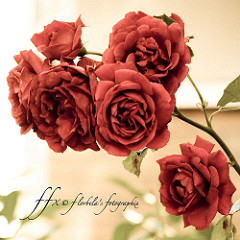

In [6]:
# Let's look at some roses 
roses = list(data_dir.glob('roses/*'))

# Displaying one of the image 
PIL.Image.open(str(roses[47]))

In [7]:
# Putting them into a function
def display_image(flower_name , rand_num = 0):
  
  image = list(data_dir.glob(f'{flower_name}/*'))
  return PIL.Image.open(str(image[rand_num]))

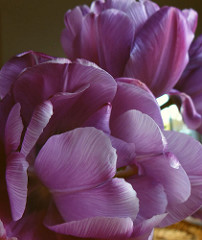

In [8]:
display_image('tulips')

### Loading using keras.preprocessing 

Loading the images using [`image_dataset_from_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory)

In [9]:
# Defining the parameters 
BATCH_SIZE = 32 
IMG_SIZE = (180 , 180)

In [10]:
# Loading the data from our directory using keras.preprocessing 

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory = data_dir, 
    validation_split = 0.2 , 
    subset = 'training',  # this will be our training
    seed = 42 , 
    image_size = IMG_SIZE , 
    batch_size = BATCH_SIZE
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [11]:
# Now let's do the same for our validation set 

valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory = data_dir , 
    validation_split = 0.2 , 
    subset = 'validation', 
    seed = 42 , 
    image_size = IMG_SIZE , 
    batch_size = BATCH_SIZE
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [12]:
# Getting the list of our class names from the "dataset attribute"
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Visualize, Visualize, Visualize....

Let's visualize a batch images

In [13]:
# We need matplotlib for this 
import matplotlib.pyplot as plt

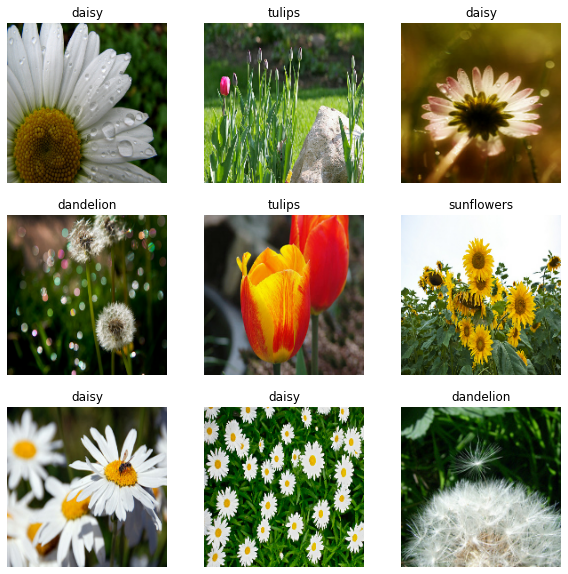

In [14]:
plt.figure(figsize = (10 , 10))
# Taking the images and labels from one batch
for images , labels in train_ds.take(1): 
  for i in range(9):
    ax = plt.subplot(3 , 3 , i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')


In [15]:
# How our batches looks like? 

for image_batch , labels_batch in train_ds:
  print(f'Image batch: {image_batch.shape}')
  print(f'Labels batch: {labels_batch.shape}')
  break

Image batch: (32, 180, 180, 3)
Labels batch: (32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of **32** images of shape `180x180x3` (the last dimension referes to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are the corresponding labels to the 32 images.

### Pre-process the data 

#### Standardize the data 
Our images have RGB channels values of [0 , 255] range. This is not ideal for neural network, in general we gotta rescale the values / standardize values to be in the [0,1]by using a **Rescaling layer**. 

In [16]:
from tensorflow.keras import layers 

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1 / 255.)

There are two ways to apply the layer: 
- By mapping it with the dataset. 
- Add as a layer inside the model definition. 

We will use the second approach 

### Configure the dataset for performance 

We're going to use buffered prefetching (cache prefetching) so we can yield data from disk without having I/O become blocking.

My understanding is it prefetches data beforehand the process, so that will be a bit faster than conventional way. 
- And cache memory is faster than RAM. 
- Located near to CPU so it can process the data really fast. 
- Disk cache is the mechanism for improving the speed that it takes to write from a disk. 

[Cache Prefetching](https://en.wikipedia.org/wiki/Cache_prefetching)

Two important method which we should use when loading data: 
- `cache()` --> keeps the image in memory after they loaded off during the first epoch. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache (disk cache). 
- `prefetch()` --> overlaps data preprocessing and model execution while training. 

**Things to look for**
- Check for AUTOUNE - [stackoverflow](https://stackoverflow.com/questions/56613155/tensorflow-tf-data-autotune)

- [About buffer_size](https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle) 

In [19]:
# Configuring the prefetching 

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size = AUTOTUNE)

- `buffer_size` in prefetch only affects the time it takes to produce the next element.
- Help us in tuning the performance of the data pipeline. 

### Train a model 

The goal of this training is to look at the mechanics that we've created using this dataset. 

In [22]:
# Creating a model 

# Number of classes 
num_classes = len(class_names)

# Building our model 
model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1 / 255.), 
  layers.Conv2D(32 , 3 , activation= 'relu'), 
  layers.MaxPooling2D() , 
  layers.Conv2D(32 , 3 , activation= 'relu'), 
  layers.MaxPooling2D(), 
  layers.Conv2D(32 , 3 , activation = 'relu'),
  layers.MaxPooling2D(),
  layers.Flatten(), 
  layers.Dense(128 , activation = 'relu'), 
  layers.Dense(num_classes)
])

In [27]:
# Compile the model 
model.compile(
    optimizer = 'adam', 
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits = True), 
    metrics = ['accuracy']
)

In [29]:
# Fitting the model 
model.fit(
    train_ds , 
    validation_data = valid_ds, 
    epochs = 5
)

Epoch 1/5
92/92 [==============================] - 40s 83ms/step - loss: 1.4831 - accuracy: 0.3335 - val_loss: 1.1734 - val_accuracy: 0.5395
Epoch 2/5
92/92 [==============================] - 2s 23ms/step - loss: 1.0791 - accuracy: 0.5572 - val_loss: 1.1294 - val_accuracy: 0.5586
Epoch 3/5
92/92 [==============================] - 2s 23ms/step - loss: 0.9359 - accuracy: 0.6393 - val_loss: 1.0764 - val_accuracy: 0.5790
Epoch 4/5
92/92 [==============================] - 2s 23ms/step - loss: 0.7888 - accuracy: 0.6955 - val_loss: 1.1163 - val_accuracy: 0.5981
Epoch 5/5
92/92 [==============================] - 2s 23ms/step - loss: 0.6531 - accuracy: 0.7527 - val_loss: 1.2866 - val_accuracy: 0.6076


## Using `tf.data` for finer control 

I planned to look into docs of `tf.data` and gets hands on at first. Then will work on this. 